**Project name:** Convolutional neural style transfer

**Student name:** Yang Hu(yh3751), HaoTian(ht2210)

#Overview

**In this project, we will introduce what Image Style Transfer is, our goals, expected outcomes, etc. in the overview. After the overview, we have total four parts.**

**In the first part, We will implement the algorithm of Leon A. Gatys et al's paper: Image Style Transfer Using Convolutional Neural Networks. It is the baseline of our project. And we make a little change for the baseline code(change verison of some library, more explaination, etc). The core principles of style transfer using convolutional neural networks will also be introduced and explained in the first part.**

**In the second part, we will implement some improvement of the algorithm in the first part. And we will introduce how we improve the algorithm detailedly.**

**In the third part, we will implement color preservation of Image style transfer. It can enable us to transfer style but not transfer color, which means the generated image will hold original color of content image. We will explain it detailedly in third part.**

**In the last part, we will implement arbitrary Style Transfer in Real-time. We will explain it detailedly in last part.**

**Parts 2, part 3, part 4 are our extensions!**

Now, let's first discuss what Image Style Transfer is. Neural style transfer consists in applying the "style" of a reference image to a target image, while conserving the "content" of the target image.

What is meant by "style" is essentially textures, colors, and visual patterns in the image, at various spatial scales, while the "content" is the higher-level macrostructure of the image. For instance, blue-and-yellow circular brush strokes are considered to be the "style" in the above example using Starry Night by Van Gogh, while the buildings in the Tuebingen photograph are considered to be the "content".

The idea of style transfer, tightly related to that of texture generation, has had a long history in the image processing community prior to the development of neural style transfer in 2015. However, as it turned out, the deep learning-based implementations of style transfer offered results unparalleled by what could be previously achieved with classical computer vision techniques, and triggered an amazing renaissance in creative applications of computer vision.

The key notion behind implementing style transfer is same idea that is central to all deep learning algorithms: we define a loss function to specify what we want to achieve, and we minimize this loss. We know what we want to achieve: conserve the "content" of the original image, while adopting the "style" of the reference image. 

why we use the convolutional neural network to achieve this?
In fact, style transfer is more like advanced texture transfer. In old days, we usually use some non-parametric algorithms, such as statistical methods. Although sometimes it looks good, it only use the low-level image features. We wish computer could use high-level semantic content to generate a better image. And convolutional neural network could do that. And it is a very important technique because it can make everyone be an artist!

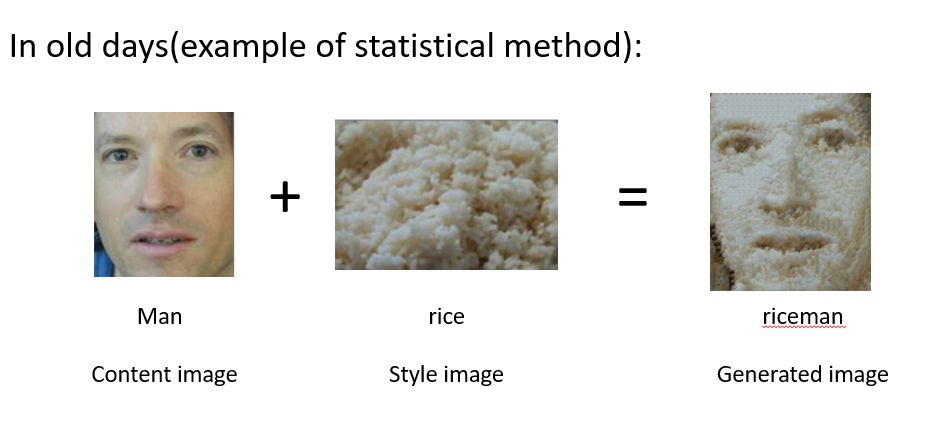

In our project, our goal is to generate a image which have both content of the content image and style of the style iamge fastly with high quality. And our expected outcomes are beautiful generated image or video. 

#Part 1: How to implement Convolutional Neural Style Transfer?

Our project belongs to unsupervised learning. And we don’t need any dataset. But we need a pretrained CNN and we use VGG19 in our project. Our VGG19 was pretrained by Imagenet. We will use VGG19's layers which are above full connection layer and we won' change any weights of VGG19. We will change values of pixels of generated image in every iteration.

At first we’ll have three images, they are content image, style image and white image. 




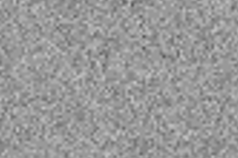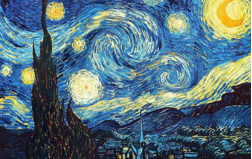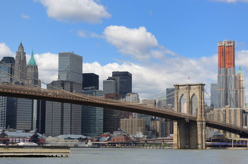

And function below is the loss function which has two parts: content loss and style loss. 




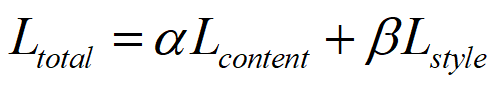

So the core of this algorithm is the loss function. Let's explain the loss more detailedly.

Let’s see content loss first.

As we already know, activations from earlier layers in a network contain local information about the image, while activations from higher layers contain increasingly global and abstract information. Formulated in a different way, the activations of the different layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore we expect the "content" of an image, which is more global and more abstract, to be captured by the representations of a top layer of a convnet. So next let's how we do in our project.

We input the content image into VGG19. Then, after the conv4_2 layer, we will get a bunch of feature maps. Let’s called them P. Then we use the white noise image to do the same thing and get a bunch of feature maps called F. Then, we could get the content loss using the formula below. It’s simple L2 distance.




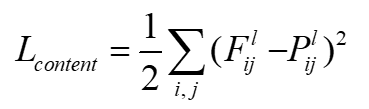

Next, let’s see the style loss. 

For the style loss, the Gatys et al. paper leverages the "Gram matrix" of a layer's activations, i.e. the inner product between the feature maps of a given layer. This inner product can be understood as representing a map of the correlations between the features of a layer. These feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically corresponds to the appearance of the textures found at this scale. So next let's how we do in our project.

First, we input the style image into the network. After the convolutional layers of conv1-1, conv2-1, conv3-1, conv4-1, conv5-1, we will get a bunch of feature maps and transfer them to the gram matrixes(G), which could measure relationships between the different feature maps. So it can express the style information. And we use a white noise image to do the same thing and we get another five Gram matrixes(A). Next, we could get the style loss. We give every layer loss a weight and sum them all to get the total style loss.




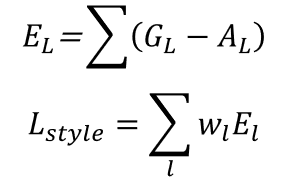

Finally, we will use this function to compute loss and take partial derivatives for each pixel of the white noise image. Then we use gradient descent to update the white noise image. This is one iteration. After many iterations, the white noise image will become our target generated image. Now let's see how we use code to implement this!

##how we use code to implement this!



Since some new library is incompatible for our code, so we need to change some library version before we start running the rest code.

In [ ]:
pip install scipy==1.2.1    #We need to reboot the code executor after running this command!

In [ ]:
%tensorflow_version 1.x
#import tensorflow as tf
import keras
keras.__version__

TensorFlow 1.x selected.


Using TensorFlow backend.


'2.3.1'

Let's start by defining the paths to the two images we consider: the style reference image and the target image. To make sure that all images processed share similar sizes (widely different sizes would make style transfer more difficult), we will later resize them all to a shared height of 400px.

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = 'content.jpg'                 #content image name
# This is the path to the style image.
style_reference_image_path = 'style.jpg'           #style image name

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)


We will need some auxiliary functions for loading, pre-processing and post-processing the images that will go in and out of the VGG19 convnet:

In [ ]:

import numpy as np
from keras.applications import vgg19
#This function is to preprocess the image to make sure it could input the VGG19 correctly.
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


Let's set up the VGG19 network. It takes as input a batch of three images: the style image, the content image, and a placeholder that will contain the generated image. A placeholder is simply a symbolic tensor, the values of which are provided externally via Numpy arrays. The style and content image are static, and thus defined using K.constant, while the values contained in the placeholder of the generated image will change over time.

In [ ]:
from keras import backend as K
#preprepare content image and style image
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

80142336/80134624 [==============================] - 2s 0us/step
Model loaded.


This is code for us to ensure we have installed correct version of tensorflow.

In [ ]:
%tensorflow_version 1.x
#to ensure we have installed correct version tensorflow.
import tensorflow as tf
print(tf.__version__)

1.15.2


These code is for the content loss.

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

These code is for the style loss.

In [ ]:
#This funciton could help us transfer the feature maps to the gram matrix.
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    gram = K.dot(features, K.transpose(features))
    return gram

#This is style loss.
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

To these two loss components, we add a third one, the "total variation loss". It is meant to encourage spatial continuity in the generated image, thus avoiding overly pixelated results. we could interpret it as a regularization loss.

In [ ]:
#This function is to get total variation loss. We can get better performance by using this loss.
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

Then prepare to start training the white noise image.

In [ ]:

# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block4_conv2'                     #We use conv4-2 to compute the content loss.
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',
                ]                      #We use conv1-1, conv2-1, conv3-1, conv4-1, conv5-1 to compute the style loss.
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4                          #This is the weight for total variation loss.
style_weight = 1.                                #This is the weight for style loss.
content_weight = 0.025                              #This is the weight for content loss.

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features) #changed
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)


In [ ]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


Finally, we can start training!

In [ ]:

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 30

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the content image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i+1)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 1
Current loss value: 28291120000.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 16s
Start of iteration 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 22124691000.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 3
Current loss value: 20516102000.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 4
Current loss value: 19943883000.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 7s
Start of iteration 5
Current loss value: 19589239000.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 6
Current loss value: 19390680000.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 7
Current loss value: 19215804000.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 7s
Start of iteration 8
Current loss value: 19088417000.0
Image saved as style_transfer_result_at_iteration_7.png
Iteration 7 completed in 6s
Start of iteration 9
Current loss value: 1898886

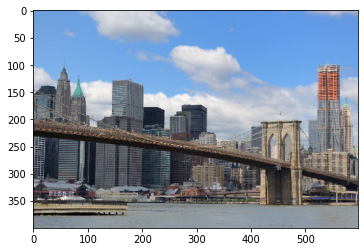

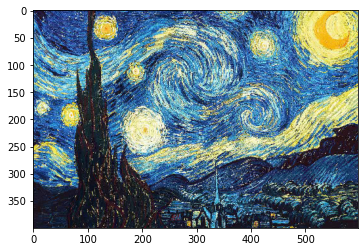

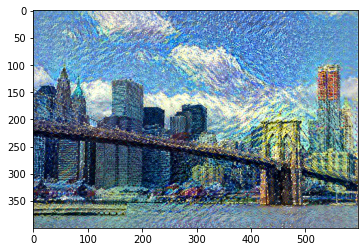

In [ ]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()
img1=img

**From the above results, we could find that this generated image has some style of style image. But the background is  not smooth. And there is a little color distortion. what's more, it will take a lot of time to generate. So the following parts(our extension) will solve these problems one by one.**

#Part2~4: Extension of Convolutional Neural Style Transfer

In the second part, we will use a seris of methods to improve quality of generated image.


##Part 2: Improvement of Style Loss





First, since more style layers will offer more information. We use all sixteen style layers of VGG-19 rather than five style layers. It will have more style features could be used by the algorithm to get a more stylized and high-quality image[3].

Second, since there are a lot of zero value in original gram matric, which will cause a non-uniform background color, so we add a value **s** to avoid this situation. Equations below will show how it implement visually[3].

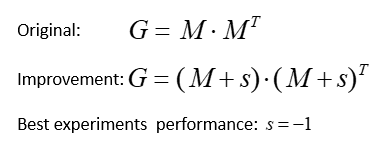

Let's see how we use code to implment this.

In [ ]:
# This is the path to the image you want to transform.
target_image_path = 'content.jpg'                 #content image name
# This is the path to the style image.
style_reference_image_path = 'style.jpg'           #style image name

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [ ]:
#This funciton could help us transfer the feature maps to the gram matrix.
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    gram = K.dot(features-1, K.transpose(features-1))           #Improvement of part 2: s=-1
    return gram

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Model loaded.


In [ ]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block4_conv2'                     #We use conv4-2 to compute the content loss.
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',
                'block1_conv2',
                'block2_conv2',
                'block3_conv2',
                'block3_conv3',
                'block3_conv4',
                'block4_conv2',
                'block4_conv3',
                'block4_conv4',
                'block5_conv2',
                'block5_conv3',
                'block5_conv4'
                ]                      #Improvement of part 2: We use all 16 convlutional layers to compute the style loss.
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4                          #This is the weight for total variation loss.
style_weight = 1.                                #This is the weight for style loss.
content_weight = 0.025                              #This is the weight for content loss.

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features) #changed
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [ ]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

evaluator_part_2 = Evaluator()

In [ ]:
result_prefix = 'style_transfer_result'
iterations = 30

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the content image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i+1)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator_part_2.loss, x,
                                     fprime=evaluator_part_2.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_2iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 1
Current loss value: 34687304000.0
Image saved as style_transfer_result_at_2iteration_0.png
Iteration 0 completed in 8s
Start of iteration 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 24242782000.0
Image saved as style_transfer_result_at_2iteration_1.png
Iteration 1 completed in 8s
Start of iteration 3
Current loss value: 22077740000.0
Image saved as style_transfer_result_at_2iteration_2.png
Iteration 2 completed in 9s
Start of iteration 4
Current loss value: 21028230000.0
Image saved as style_transfer_result_at_2iteration_3.png
Iteration 3 completed in 9s
Start of iteration 5
Current loss value: 20493531000.0
Image saved as style_transfer_result_at_2iteration_4.png
Iteration 4 completed in 9s
Start of iteration 6
Current loss value: 20109308000.0
Image saved as style_transfer_result_at_2iteration_5.png
Iteration 5 completed in 9s
Start of iteration 7
Current loss value: 19850134000.0
Image saved as style_transfer_result_at_2iteration_6.png
Iteration 6 completed in 9s
Start of iteration 8
Current loss value: 19645410000.0
Image saved as style_transfer_result_at_2iteration_7.png
Iteration 7 completed in 9s
Start of iteration 9
Current loss value: 

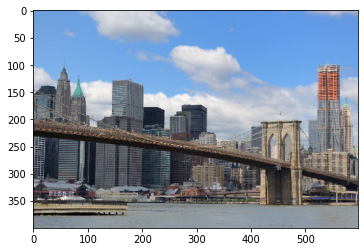

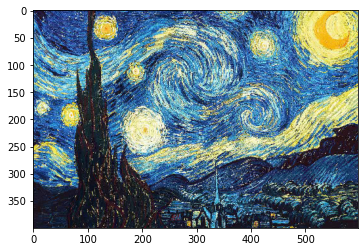

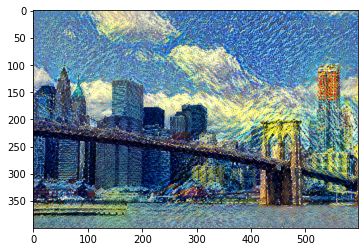

In [ ]:


# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()
img2=img

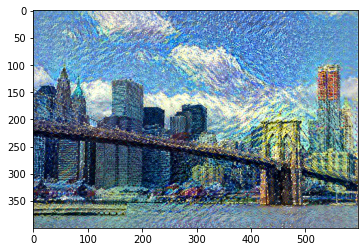

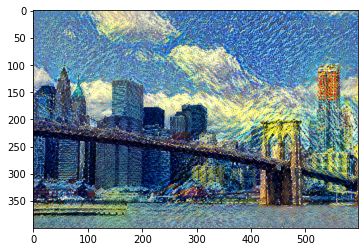

In [ ]:
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

**From the result above(top image is part1 image, bottom image is part2 image), we could find that under the same iteration number, the new generated image(part2) is more smooth than the old one and have a better performance.**

##Part3: Color Preservation 


In the third part, we will explore how to implement color preservation.

From the results above we could find that there is a little color distortion. The generated image will lost the content color. What if we want the generated image have the original content color. So in this section will use some technique to achieve this.

To achieve that, we first convert the content image and generated image from RGB to YIQ(Ycbcr) color space, then we use the Y component of the generated image and I and Q components to form a new image[4], and this new image has original color. 

That is because Y is illumination, people are often more sensitive with illumination, so we retain the illumination of the generated image and change the I, Q color component to make generated image match the original color and have style of the style image.

Now, let's see how we use code to implement this!

In [ ]:
#install necessary library.
pip install scipy==1.2.1

In [ ]:
#install necessary library.
pip install Pillow==6.1.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `fromimage` is deprecated!
`fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
Use ``np.asarray(im)`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `fromimage` is deprecated!
`fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
Use ``np.asarray(im)`` inste

Image saved as Color_Preservation.png


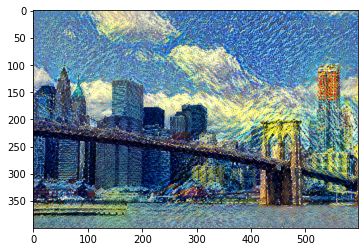

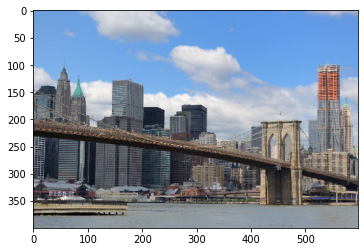

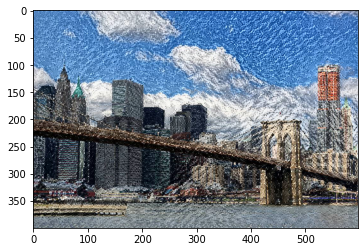

<Figure size 432x288 with 0 Axes>

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#input content and generated pictures
generated_path = result_prefix + '_at_2iteration_%d.png' % (iterations-1)
generated = load_img(generated_path, target_size=(img_height, img_width))
content = load_img(target_image_path, target_size=(img_height, img_width))
plt.imshow(generated)
plt.figure()
plt.imshow(content)
plt.figure()


generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')
content = fromimage(toimage(content, mode='RGB'), mode='YCbCr')

generated[:, :, 1:] = content[:, :, 1:]

generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')

plt.imshow(generated )
plt.figure()

C_fname ='Color_Preservation.png'
imsave(C_fname, generated)
print('Image saved as', C_fname)




**From the result above(from top to bottom they are generated image in part2, content image and new generated image in part3), we could find that the new generated image has  preserved the content color, which proved it is successful.**


##Part4: Arbitrary Style Transfer in Real-time 

The key point of real time style transfer is the transfer time. However, the original method is a long gradient descent process. 


The framework of Gatys et al.[2] is based on a slow optimization process that iteratively updates the image to minimize a content loss and a style loss computed by a loss network. It can take minutes to converge even with modern GPUs. On-device processing in mobile applications is therefore too slow to be practical. A common workaround is to replace the optimization process with a feed-forward neural network that is trained to minimize the same objective. These feed-forward style transfer approaches are about three orders of magnitude faster than the optimization-based alternative, opening the door to real- time applications.

Although the feed-forward neural network improve the speed of  optimization a little, it only is trained for the same object. In another word, one network can only transfer one style. Those two problems make people try another ways.


Xuhuang et al.[5] found that the mean and variance of the feature map represent the style of the image. It offers a new approach.
So we only need to calculate the mean and variance of one style feature map and use the mean and variance of this style feature map to normalize the content feature map, then transfer this feature map to image, we can get a transfer style image.


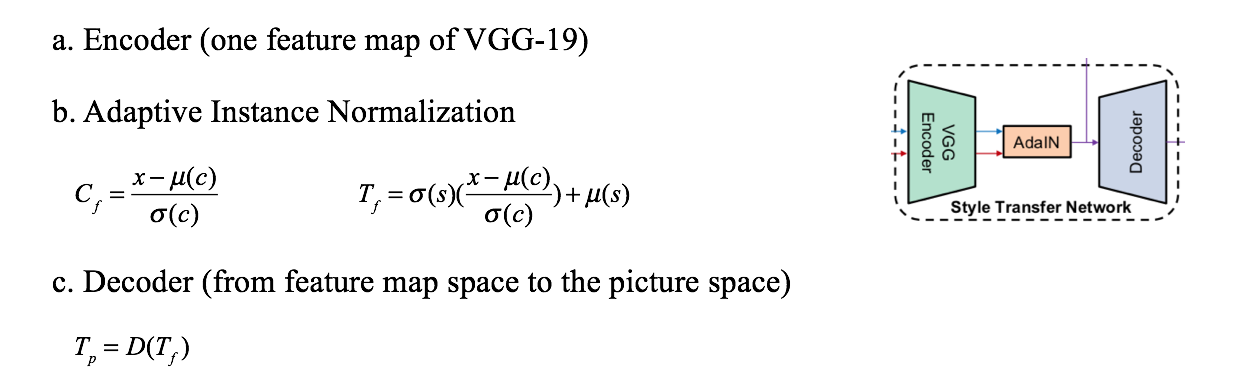

Cf is a content-normalized feature map by minus the mean and divide the variance of content feature map. Tf is a style-normalized feature map by the mean and variance of one layer style feature map.
The encoder are the VGG-19 network to some layer.The decoder mostly mirrors the encoder, with all pooling layers replaced by nearest up-sampling to reduce checker- board effects.



So, we can see this method only need two steps to get the transfer style image. It is a amazing speed and can realize different style transfer by changing the mean and variance of different style pictures .

Here is the code :（reference: https://github.com/naoto0804/pytorch-AdaIN）

First, we need to install all necessary libraries.

In [ ]:
#Install all necessary libraries

!pip install numpy==1.17.2
!pip install Pillow==6.1.0
!pip install protobuf==3.9.1
!pip install six==1.12.0
!pip install tensorboardX==1.8
!pip install torch==1.2.0
!pip install torchvision==0.4.0
!pip install tqdm==4.35.0

In [ ]:
#Install other necessary libraries

import os
import io
import cv2
from PIL import Image
import imageio
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
from IPython.display import HTML
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython import display as ipythondisplay
from IPython.display import Image as ipythonimage
%matplotlib inline

!git clone https://github.com/naoto0804/pytorch-AdaIN.git
%cd /content/pytorch-AdaIN

!mkdir models
%cd /content/pytorch-AdaIN/models
!gdown https://drive.google.com/uc?id=108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y
!gdown https://drive.google.com/uc?id=1w9r1NoYnn7tql1VYG3qDUzkbIks24RBQ
%cd /content/pytorch-AdaIN

Then we need to upload a video to prepare style transfer.

In [ ]:
# upload a video
!rm -rf video
!mkdir video
uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one video at a time!')

vid = uploaded[0]
os.rename(vid, vid.replace(" ", ""))
vid = vid.replace(" ", "")
!mv -f $vid video/driving.mp4
vid = '/content/pytorch-AdaIN/video/driving.mp4'

fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))

Next we need to split video into frames

In [ ]:
#Split video into frames

!rm -rf frames
!mkdir frames

frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))
fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
vidcap = cv2.VideoCapture(vid)
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("frames/frame%09d.jpg" % count, image)
  success,image = vidcap.read()
  count += 1

frames = []
fram = os.listdir("/content/pytorch-AdaIN/frames")
fram.sort()

fram_path = '/content/pytorch-AdaIN/frames/' + fram[0]
print("First frame:\n")
display(Image.open(fram_path).resize((300, 200)))

After that, we need to upload the style image.

In [ ]:
# Upload image (style)


uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
pic_name = "photo." + fn.split(".")[-1]
!mv -f $fn $pic_name

display(Image.open(pic_name).resize((300, 200)))

Next, We prepare to start style transfer.

In [ ]:
# Style Transfer

%%time
!rm -rf stylized_frames
!mkdir stylized_frames

im = Image.open(fram_path)
(width, height) = im.size
min_size_cont = min(width, height)

im = Image.open(pic_name)
(width, height) = im.size
min_size_styl = min(width, height)

temp_path = '/content/pytorch-AdaIN/frames'
output_path = '/content/pytorch-AdaIN/stylized_frames'
!CUDA_VISIBLE_DEVICES=0 python test.py --content_dir $temp_path --style $pic_name --output $output_path --content_size $min_size_cont --style_size $min_size_styl
clear_output()

In [ ]:
# Join frames in a video

!ffmpeg -y -i $vid -vn -ar 44100 -ac 2 -ab 192K -f mp3 sound.mp3
staffs = []
img = os.listdir("/content/pytorch-AdaIN/stylized_frames")
img.sort()
for i in img:
  staffs.append("/content/pytorch-AdaIN/stylized_frames/"+i)

staff = cv2.imread(staffs[0])  # get size from the 1st frame
writer = cv2.VideoWriter(
    'stylized_video.mp4',
    cv2.VideoWriter_fourcc(*'MP4V'),   # codec (*'DIVX', *'MP4V', *'FMP4', *'MJPG', *'XVID', *'MP4S')
    fps_of_video,  # fps
    (staff.shape[1], staff.shape[0]),  # width, height
    isColor=len(staff.shape) > 2)
for staff in map(cv2.imread, staffs):
    writer.write(staff)
writer.release()

dstvid = 'stylized_video.mp4'
tmpfile = dstvid.replace('.mp4', '-audio.mp4')
!ffmpeg -i sound.mp3 -i $dstvid $tmpfile
!rm -rf $dstvid
!mv -f $tmpfile $dstvid

We have finished style transfer, now let's see how performance it is.

In [ ]:
# Open the final video

display(mpy.ipython_display("/content/pytorch-AdaIN/stylized_video.mp4", height=400, autoplay=1, loop=1, maxduration=600))

In [ ]:
# Download the final video 

files.download('/content/pytorch-AdaIN/stylized_video.mp4')

**Since the result is a vedio, we put the result on the zip. From the result we could find that the video has style of the style image, which proved these code implement the method of Arbitrary Style Transfer in Real-time successfully.**

#Citation


[1] Leon A. Gatys, Alexander S. Ecker, Matthias Bethge. A Neural Algorithm of Artistic Style. arXiv:1508.06576. 2015.

[2] L. A. Gatys, A. S. Ecker and M. Bethge, "Image Style Transfer Using Convolutional Neural Networks," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 2414-2423, doi: 10.1109/CVPR.2016.265.

[3]Novak R, Nikulin Y. Improving the neural algorithm of artistic style[J]. arXiv preprint arXiv:1605.04603, 2016.

[4]Gatys L A, Bethge M, Hertzmann A, et al. Preserving color in neural artistic style transfer[J]. arXiv preprint arXiv:1606.05897, 2016.

[5]Huang X, Belongie S. Arbitrary style transfer in real-time with adaptive instance normalization[C]//Proceedings of the IEEE International Conference on Computer Vision. 2017: 1501-1510.